<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#General-parameters" data-toc-modified-id="General-parameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>General parameters</a></span></li><li><span><a href="#Some-functions" data-toc-modified-id="Some-functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Some functions</a></span></li><li><span><a href="#Plotting-functions" data-toc-modified-id="Plotting-functions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Plotting functions</a></span></li></ul></li><li><span><a href="#Comparison-between-rules" data-toc-modified-id="Comparison-between-rules-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Comparison between rules</a></span><ul class="toc-item"><li><span><a href="#An-example" data-toc-modified-id="An-example-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>An example</a></span></li></ul></li><li><span><a href="#Comparison-to-plot-of-training" data-toc-modified-id="Comparison-to-plot-of-training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparison to plot of training</a></span><ul class="toc-item"><li><span><a href="#Training-time" data-toc-modified-id="Training-time-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Training time</a></span></li><li><span><a href="#Inter-pulse-interval" data-toc-modified-id="Inter-pulse-interval-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Inter-pulse-interval</a></span></li><li><span><a href="#Tau_z" data-toc-modified-id="Tau_z-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Tau_z</a></span></li></ul></li><li><span><a href="#See-the-evolution-of-weights" data-toc-modified-id="See-the-evolution-of-weights-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>See the evolution of weights</a></span></li></ul></div>

# Preamble

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

from network import Protocol, NetworkManager
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities, calculate_triad_connectivity
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

## General parameters

In [2]:
epsilon = 1e-7
vmin = -6.0
remove = 0.010
g_a_big = 3.0

strict_maximum = True

dt = 0.001
tau_s = 0.010
tau_a = 0.250
g_I = 100.0
g_a = 5.0
G = 50.0

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 10
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

## Some functions

In [3]:
from connectivity_functions import softmax, get_w_pre_post, get_beta, strict_max


class Network2:
    def __init__(self, hypercolumns, minicolumns, G=1.0, tau_s=0.010, tau_z_pre=0.050, tau_z_post=0.005,
                 tau_a=0.250, tau_p=10.0, g_a=1.0, g_I=10.0, sigma_out=0.0, epsilon=1e-60, g_beta=1.0, prng=np.random,
                 strict_maximum=True, perfect=False, normalized_currents=True):

        # Random number generator
        self.prng = prng
        self.sigma_out = sigma_out   # The variance that the system would have on the steady state if were to have it
        self.sigma_in = sigma_out * np.sqrt(2 / tau_s)    # Ornstein-Uhlenbeck process
        self.epsilon = epsilon

        # Network parameters
        self.hypercolumns = hypercolumns
        self.minicolumns = minicolumns

        self.n_units = self.hypercolumns * self.minicolumns

        # Network variables
        self.strict_maximum = strict_maximum
        self.perfect = perfect
        self.normalized_current = normalized_currents
        if self.normalized_current:
            self.normalized_constant = self.hypercolumns
        else:
            self.normalized_constant = 1.0

        #  Dynamic Parameters
        self.tau_s = tau_s
        self.tau_a = tau_a
        self.tau_p = tau_p
        self.r = self.tau_s / self.tau_a
        self.g_beta = g_beta
        self.g_a = g_a
        self.g_I = g_I
        self.tau_z_pre = tau_z_pre
        self.tau_z_post = tau_z_post
        self.G = G

        # State variables
        self.o = np.full(shape=self.n_units, fill_value=0.0)
        self.s = np.full(shape=self.n_units, fill_value=0.0)
        self.a = np.full(shape=self.n_units, fill_value=0.0)
        self.I = np.full(shape=self.n_units, fill_value=0.0)

        # Current values
        self.i = np.full(shape=self.n_units, fill_value=0.0)
        self.z_pre = np.full(shape=self.n_units, fill_value=0.0)
        self.z_post = np.full(shape=self.n_units, fill_value=0.0)
        self.z_co = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

        # Keeping track of the probability / connectivity
        self.t_p = 0.0
        self.p_pre = np.full(shape=self.n_units, fill_value=0.0)
        self.p_post = np.full(shape=self.n_units, fill_value=0.0)
        self.P = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)
        self.w = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)
        self.beta = np.full(shape=self.n_units, fill_value=0.0)

    def parameters(self):
        """
        Get the parameters of the model

        :return: a dictionary with the parameters
        """
        parameters = {'tau_s': self.tau_s, 'tau_z_post': self.tau_z_post, 'tau_z_pre': self.tau_z_pre,
                      'tau_a': self.tau_a, 'g_a': self.g_a, 'g_I':self.g_I,  'epsilon': self.epsilon,
                      'G': self.G, 'sigma_out':self.sigma_out, 'sigma_in': self.sigma_in,
                      'perfect': self.perfect, 'strict_maximum': self.strict_maximum}

        return parameters

    def reset_values(self, keep_connectivity=True):
        # State variables
        self.o = np.full(shape=self.n_units, fill_value=0.0)
        self.s = np.full(shape=self.n_units, fill_value=0.0)

        self.a = np.full(shape=self.n_units, fill_value=0.0)
        self.I = np.full(shape=self.n_units, fill_value=0.0)

        # Current values
        self.i = np.full(shape=self.n_units, fill_value=0.0)
        self.z_pre = np.full(shape=self.n_units, fill_value=0.0)
        self.z_post = np.full(shape=self.n_units, fill_value=0.0)
        self.z_co = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

        if not keep_connectivity:
            self.beta = np.full(shape=self.n_units, fill_value=0.0)
            self.w = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

            self.p_pre = np.full(shape=self.n_units, fill_vale=0.0)
            self.p_post = np.full(shape=self.n_units, fill_value=0.0)
            self.P = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

    def update_continuous(self, dt=1.0, sigma=None):
        # Get the noise
        if sigma is None:
            noise = self.sigma_in * np.sqrt(dt) * self.prng.normal(0, 1.0, self.n_units)
        else:
            noise = sigma

        # Calculate currents
        self.i = self.w @ self.o / self.normalized_constant
        if self.perfect:
            self.s = self.i + self.g_beta * self.beta - self.g_a * self.a + self.g_I * self.I + noise
        else:
            self.s += (dt / self.tau_s) * (self.i  # Current
                                           + self.g_beta * self.beta  # Bias
                                           + self.g_I * self.I  # Input current
                                           - self.g_a * self.a  # Adaptation
                                           - self.s)  # s follow all of the s above
            self.s += noise
        # Non-linearity
        if self.strict_maximum:
            self.o = strict_max(self.s, minicolumns=self.minicolumns)
        else:
            self.o = softmax(self.s, G=self.G, minicolumns=self.minicolumns)

        # Update the adaptation
        self.a += (dt / self.tau_a) * (self.o - self.a)

    def update_z_values(self, dt):
        # Updated the z-traces
        self.z_pre += (dt / self.tau_z_pre) * (self.o - self.z_pre)
        self.z_post += (dt / self.tau_z_post) * (self.o - self.z_post)
        self.z_co = np.outer(self.z_post, self.z_pre)

    def update_probabilities(self, dt):
        self.p_pre += (dt / self.tau_p) * (self.z_pre - self.p_pre)
        self.p_post += (dt / self.tau_p) * (self.z_post - self.p_post)
        self.P += (dt / self.tau_p) * (self.z_co - self.P)

    def update_weights(self):
        # Update the connectivity
        self.beta = get_beta(self.p_post, self.epsilon)
        self.w = get_w_pre_post(self.P, self.p_pre, self.p_post, self.epsilon, diagonal_zero=False)

In [4]:
class Network:
    def __init__(self, hypercolumns, minicolumns, G=1.0, tau_s=0.010, tau_z_pre=0.050, tau_z_post=0.005,
                 tau_a=0.250, g_a=1.0, g_I=10.0, sigma_out=0.0, epsilon=1e-60, g_beta=1.0, prng=np.random,
                 strict_maximum=True, perfect=False, normalized_currents=True):

        # Random number generator
        self.prng = prng
        self.sigma_out = sigma_out   # The variance that the system would have on the steady state if were to have it
        self.sigma_in = sigma_out * np.sqrt(2 / tau_s)    # Ornstein-Uhlenbeck process
        self.epsilon = epsilon

        # Network parameters
        self.hypercolumns = hypercolumns
        self.minicolumns = minicolumns

        self.n_units = self.hypercolumns * self.minicolumns

        # Network variables
        self.strict_maximum = strict_maximum
        self.perfect = perfect
        self.normalized_current = normalized_currents
        if self.normalized_current:
            self.normalized_constant = self.hypercolumns
        else:
            self.normalized_constant = 1.0

        #  Dynamic Parameters
        self.tau_s = tau_s
        self.tau_a = tau_a
        self.r = self.tau_s / self.tau_a
        self.g_beta = g_beta
        self.g_a = g_a
        self.g_I = g_I
        self.tau_z_pre = tau_z_pre
        self.tau_z_post = tau_z_post
        self.G = G

        # State variables
        self.o = np.full(shape=self.n_units, fill_value=0.0)
        self.s = np.full(shape=self.n_units, fill_value=0.0)
        self.a = np.full(shape=self.n_units, fill_value=0.0)
        self.I = np.full(shape=self.n_units, fill_value=0.0)

        # Current values
        self.i = np.full(shape=self.n_units, fill_value=0.0)
        self.z_pre = np.full(shape=self.n_units, fill_value=0.0)
        self.z_post = np.full(shape=self.n_units, fill_value=0.0)
        self.z_co = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

        # Keeping track of the probability / connectivity
        self.t_p = 0.0
        self.p_pre = np.full(shape=self.n_units, fill_value=0.0)
        self.p_post = np.full(shape=self.n_units, fill_value=0.0)
        self.P = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)
        self.w = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)
        self.beta = np.full(shape=self.n_units, fill_value=0.0)

    def parameters(self):
        """
        Get the parameters of the model

        :return: a dictionary with the parameters
        """
        parameters = {'tau_s': self.tau_s, 'tau_z_post': self.tau_z_post, 'tau_z_pre': self.tau_z_pre,
                      'tau_a': self.tau_a, 'g_a': self.g_a, 'g_I':self.g_I,  'epsilon': self.epsilon,
                      'G': self.G, 'sigma_out':self.sigma_out, 'sigma_in': self.sigma_in,
                      'perfect': self.perfect, 'strict_maximum': self.strict_maximum}

        return parameters

    def reset_values(self, keep_connectivity=True):
        # State variables
        self.o = np.full(shape=self.n_units, fill_value=0.0)
        self.s = np.full(shape=self.n_units, fill_value=0.0)

        self.a = np.full(shape=self.n_units, fill_value=0.0)
        self.I = np.full(shape=self.n_units, fill_value=0.0)

        # Current values
        self.i = np.full(shape=self.n_units, fill_value=0.0)
        self.z_pre = np.full(shape=self.n_units, fill_value=0.0)
        self.z_post = np.full(shape=self.n_units, fill_value=0.0)
        self.z_co = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

        if not keep_connectivity:
            self.beta = np.full(shape=self.n_units, fill_value=0.0)
            self.w = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

            self.p_pre = np.full(shape=self.n_units, fill_vale=0.0)
            self.p_post = np.full(shape=self.n_units, fill_value=0.0)
            self.P = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

    def update_continuous(self, dt=1.0, sigma=None):
        # Get the noise
        if sigma is None:
            noise = self.sigma_in * np.sqrt(dt) * self.prng.normal(0, 1.0, self.n_units)
        else:
            noise = sigma

        # Calculate currents
        self.i = self.w @ self.o / self.normalized_constant
        if self.perfect:
            self.s = self.i + self.g_beta * self.beta - self.g_a * self.a + self.g_I * self.I + noise
        else:
            self.s += (dt / self.tau_s) * (self.i  # Current
                                           + self.g_beta * self.beta  # Bias
                                           + self.g_I * self.I  # Input current
                                           - self.g_a * self.a  # Adaptation
                                           - self.s)  # s follow all of the s above
            self.s += noise
        # Non-linearity
        if self.strict_maximum:
            self.o = strict_max(self.s, minicolumns=self.minicolumns)
        else:
            self.o = softmax(self.s, G=self.G, minicolumns=self.minicolumns)

        # Update the adaptation
        self.a += (dt / self.tau_a) * (self.o - self.a)

    def update_z_values(self, dt):
        # Updated the z-traces
        self.z_pre += (dt / self.tau_z_pre) * (self.o - self.z_pre)
        self.z_post += (dt / self.tau_z_post) * (self.o - self.z_post)
        self.z_co = np.outer(self.z_post, self.z_pre)
   
    def update_probabilities(self, dt):
        if self.t_p > 0.0:
            time_factor = dt / self.t_p
            self.p_pre += time_factor * (self.z_pre - self.p_pre)
            self.p_post += time_factor * (self.z_post - self.p_post)
            self.P += time_factor * (self.z_co - self.P)
        self.t_p += dt

    def update_weights(self):
        # Update the connectivity
        self.beta = get_beta(self.p_post, self.epsilon)
        self.w = get_w_pre_post(self.P, self.p_pre, self.p_post, self.epsilon, diagonal_zero=False)

## Plotting functions

In [5]:
def calculate_relevant_connectivities(w_dic, manager):
    results_dictionary = {}
    w_self_theo = w_dic['w11']
    results_dictionary['w_self_theo'] = w_self_theo 
    w_self_sim = manager.nn.w[index1, index1]
    results_dictionary['w_self_sim'] = w_self_sim
    
    w_next_theo = w_dic['w21']
    results_dictionary['w_next_theo'] = w_next_theo
    w_next_sim = manager.nn.w[index2, index1]
    results_dictionary['w_next_sim'] = w_next_sim

    results_dictionary['w_prev_theo'] = w_dic['w12']
    results_dictionary['w_prev_sim'] = manager.nn.w[index1, index2]

    results_dictionary['w_rest_ahead_theo'] = w_dic['w31']
    results_dictionary['w_rest_ahead_sim'] = manager.nn.w[index3, index1]

    results_dictionary['w_rest_back_theo'] = w_dic['w13']
    results_dictionary['w_rest_back_sim'] = manager.nn.w[index1, index3]

    results_dictionary['beta_theo'] = w_dic['beta1']
    results_dictionary['beta_sim'] = manager.nn.beta[index1]
    
    w_next_diff_theo = w_self_theo - w_next_theo
    results_dictionary['w_next_diff_theo'] = w_next_diff_theo
    w_next_diff_sim = w_self_sim - w_next_sim
    results_dictionary['w_next_diff_sim'] = w_next_diff_sim
    results_dictionary['B_theo'] = w_next_diff_theo / g_a_big
    results_dictionary['B_sim'] = w_next_diff_sim / g_a_big
    
    T = manager.calculate_persistence_time_matrix()
    results_dictionary['T_per'] = T[index2, index1]
                       
    return results_dictionary


values_to_save_string = ['w_self_theo', 'w_self_sim', 'w_next_theo', 'w_next_sim', 
                         'w_rest_ahead_theo', 'w_rest_ahead_sim', 'w_prev_theo', 'w_prev_sim', 
                         'w_rest_back_theo', 'w_rest_back_sim', 'w_next_diff_theo', 'w_next_diff_sim', 
                         'B_theo', 'B_sim', 'T_per']

values_to_plot_string1 = ['w_self', 'w_next', 'w_prev']

values_to_plot_string2 = ['B', 'w_next_diff']
values_to_plot_string_rest = ['w_rest_back', 'w_rest_ahead']
values_to_plot_time = ['T_per']

labels_dic = {'w_self': r'$w_{self}$', 'w_next':r'$w_{next}$', 'w_rest':r'$w_{rest}$', 'w_prev':r'$w_{back}$',
              'w_next_diff':r'$\Delta w_{next}$', 'B': 'B', 
              'w_rest_ahead':r'$w_{rest_{ahead}}$', 'w_rest_back': r'$w_{rest_{back}}$', 
              'T_per':r'$T_{per}$'}


def calculate_connectivites(tt, ipi, tau_z_pre, tau_z_post=0.005):

    strict_maximum = True

    g_a = g_a_big
    g_I = 10.0
    tau_a = 0.250
    G = 1.0
    sigma_out = 0.0
    tau_s = 0.010
    tau_p = 10.0
    tau_z_pre = tau_z_pre
    tau_z_post = tau_z_post

    hypercolumns = 1
    minicolumns = 10
    n_patterns = 10

    # Training protocol
    training_times_base = tt
    training_times = [training_times_base for i in range(n_patterns)]
    ipi_base = ipi
    inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
    inter_sequence_interval = 0.0
    resting_time = 0.0
    epochs = 100

    # Manager properties
    values_to_save = ['o']

    # Neural Network
    nn = Network2(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                     tau_a=tau_a, tau_p=tau_p, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                     strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    # Build the representation
    representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                            minicolumns=minicolumns)

    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)
    

    tt1 = training_times[index1]
    tt2 = training_times[index2]
    tt3 = training_times[index3]
    ipi1 = inter_pulse_intervals[index1]
    ipi2 = inter_pulse_intervals[index2]
    ipi3 = inter_pulse_intervals[index3]

    base_time = training_times_base
    base_ipi = ipi_base
    resting_time = resting_time
    n_patterns = n_patterns

    w_dic = calculate_triad_connectivity(tt1, tt2, tt3, ipi1, ipi2, tau_z_pre, tau_z_post, 
                                         base_time, base_ipi, resting_time, n_patterns)
    
    return calculate_relevant_connectivities(w_dic, manager)


def plot_weights(results_dictionary, ax=None, legend=True, x_label=True, y_label=True, 
                 both_labels=True, add_diff=False):
    if add_diff:
        values_to_plot = ['w_self', 'w_next', 'w_prev', 'w_next_diff']
    else:
        values_to_plot = values_to_plot_string1
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    x_vector = results_dictionary['input']
    xlabel = results_dictionary['xlabel']
    
    for index, value in enumerate(values_to_plot): 
        label = labels_dic[value]
        ax.plot(x_vector, results_dictionary[value + '_theo'], '-', color=colors[index], ms=ms, lw=lw, label=label)
        if both_labels:
            ax.plot(x_vector, results_dictionary[value + '_sim'], 'o', color=colors[index], ms=ms, lw=lw, label='sim')
        else:
            ax.plot(x_vector, results_dictionary[value + '_sim'], 'o', color=colors[index], ms=ms, lw=lw)

    if x_label:
        ax.set_xlabel(xlabel)
    if y_label:
        ax.set_ylabel(r'$w$')
    ax.axhline(0, ls='--', color='gray')
    ax.axvline(0, ls='--', color='gray')

    if legend:
        ax.legend(frameon=False)
    
    return ax 


def plot_B(results_dictionary, ax=None, legend=True, x_label=True, y_label=True, both_labels=True):
    values_to_plot_string = values_to_plot_string2
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    x_vector = results_dictionary['input']
    xlabel = results_dictionary['xlabel']
    for index, value in enumerate(values_to_plot_string): 
        label = labels_dic[value]
        ax.plot(x_vector, results_dictionary[value + '_theo'], '-', color=colors[index + 3], ms=ms, lw=lw, label=label)
        if both_labels:
            ax.plot(x_vector, results_dictionary[value + '_sim'], 'o', color=colors[index + 3], ms=ms, lw=lw, label='sim')
        else:
            ax.plot(x_vector, results_dictionary[value + '_sim'], 'o', color=colors[index + 3], ms=ms, lw=lw)
        
    if x_label:
        ax.set_xlabel(xlabel)
    if y_label:
        ax.set_ylabel(r'$B$')
    
    ax.axhline(1.0, ls='--', color='gray')
    ax.axhline(0, ls='--', color='gray')
    ax.axvline(0, ls='--', color='gray')
    
    if legend:
        ax.legend(frameon=False)
    
    return ax

def plot_rest_weights(results_dictionary, ax=None, legend=True, x_label=True, y_label=True):
    values_to_plot_string = values_to_plot_string_rest
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    x_vector = results_dictionary['input']
    xlabel = results_dictionary['xlabel']
    for index, value in enumerate(values_to_plot_string): 
        label = labels_dic[value]
        ax.plot(x_vector, results_dictionary[value + '_theo'], '-', color=colors[index], ms=ms, lw=lw, label=label)
        ax.plot(x_vector, results_dictionary[value + '_sim'], 'o', color=colors[index], ms=ms, lw=lw, label='sim')

    if x_label:
        ax.set_xlabel(xlabel)
    if y_label:
        ax.set_ylabel(r'$w$')
    ax.axhline(0, ls='--', color='gray')
    ax.axvline(0, ls='--', color='gray')
    
    if legend:
        ax.legend(frameon=False)

    return ax


def plot_persistent_times(results_dictionary, ax=None, legend=True, x_label=True, 
                          y_label=True, add_zero_lines=True):
    values_to_plot_string = values_to_plot_time
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    x_vector = results_dictionary['input']
    xlabel = results_dictionary['xlabel']
    for index, value in enumerate(values_to_plot_string): 
        label = labels_dic[value]
        ax.plot(x_vector, results_dictionary[value], '-o', color=colors[index + 5], ms=ms, lw=lw, label=label)

    if x_label:
        ax.set_xlabel(xlabel)
    if y_label:
        ax.set_ylabel(r'$T_{per} (s)$')
    
    if add_zero_lines:
        # ax.axhline(0, ls='--', color='gray')
        ax.axvline(0, ls='--', color='gray')
    
    if legend:
        ax.legend(frameon=False)

    return ax

# Comparison between rules

## An example

In [6]:
sigma_out = 0.00
tau_z_pre = 0.050
tau_z_post = 0.005
g_a = 2.0

hypercolumns = 1
minicolumns = 5
n_patterns = minicolumns


# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.00
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0
resting_time = 0.0
epochs = 50
T_persistence = 0.100

# Manager properties
values_to_save = ['s', 'o', 'w', 'z_pre', 'beta', 'p_post', 'p_pre', 'P']


# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)


# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
manager.run_network_protocol(protocol=protocol, plasticity_on=True)
# Set the persistent time
#manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)


../network.py:349: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pattern == epoch_end_string:
../connectivity_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  x = P / outer


epochs 0
epochs 1
epochs 2
epochs 3
epochs 4
epochs 5
epochs 6
epochs 7
epochs 8
epochs 9
epochs 10
epochs 11
epochs 12
epochs 13
epochs 14
epochs 15
epochs 16
epochs 17
epochs 18
epochs 19
epochs 20
epochs 21
epochs 22
epochs 23
epochs 24
epochs 25
epochs 26
epochs 27
epochs 28
epochs 29
epochs 30
epochs 31
epochs 32
epochs 33
epochs 34
epochs 35
epochs 36
epochs 37
epochs 38
epochs 39
epochs 40
epochs 41
epochs 42
epochs 43
epochs 44
epochs 45
epochs 46
epochs 47
epochs 48
epochs 49


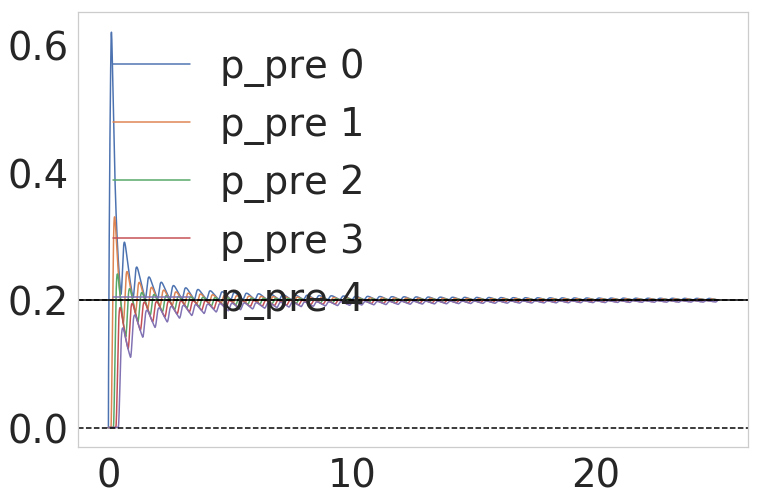

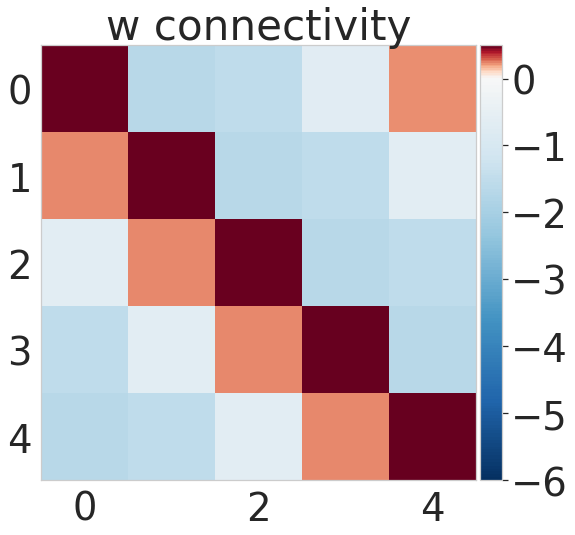

In [7]:
w = manager.history['w']
o = manager.history['o']
z_pre = manager.history['z_pre']
p_pre = manager.history['p_pre']
p_post = manager.history['p_post']
P = manager.history['P']
s = manager.history['s']
beta = manager.history['beta']

for index in range(minicolumns):
    plt.plot(manager.time, p_pre[:, index], label='p_pre ' + str(index))

plt.axhline(1 / minicolumns , ls='--', color='black')
plt.axhline(training_times_base * epochs / (manager.T_training_total) , color='black', ls='-')
plt.axhline(0, ls='--', color='black')

plt.legend(frameon=False)
#plt.xlim([150, 158])

plot_weight_matrix(manager, vmin=vmin)
w1 = np.copy(nn.w)
P1 = np.copy(nn.P)
p1_pre = np.copy(nn.p_pre)
p1_post = np.copy(nn.p_post)

In [8]:
sigma_out = 0.00
tau_z_pre = 0.050
tau_z_post = 0.005
tau_p = 5.0
g_a = 2.0

hypercolumns = 1
minicolumns = 5
n_patterns = minicolumns


# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.00
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0
resting_time = 0.0
epochs = 50
T_persistence = 0.100

# Manager properties
values_to_save = ['s', 'o', 'w', 'z_pre', 'beta', 'p_post', 'p_pre', 'P']


# Neural Network
nn = Network2(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, tau_p=tau_p, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)


# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
manager.run_network_protocol(protocol=protocol, plasticity_on=True)
# Set the persistent time
#manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)



../network.py:349: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pattern == epoch_end_string:
../connectivity_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  x = P / outer


epochs 0
epochs 1
epochs 2
epochs 3
epochs 4
epochs 5
epochs 6
epochs 7
epochs 8
epochs 9
epochs 10
epochs 11
epochs 12
epochs 13
epochs 14
epochs 15
epochs 16
epochs 17
epochs 18
epochs 19
epochs 20
epochs 21
epochs 22
epochs 23
epochs 24
epochs 25
epochs 26
epochs 27
epochs 28
epochs 29
epochs 30
epochs 31
epochs 32
epochs 33
epochs 34
epochs 35
epochs 36
epochs 37
epochs 38
epochs 39
epochs 40
epochs 41
epochs 42
epochs 43
epochs 44
epochs 45
epochs 46
epochs 47
epochs 48
epochs 49


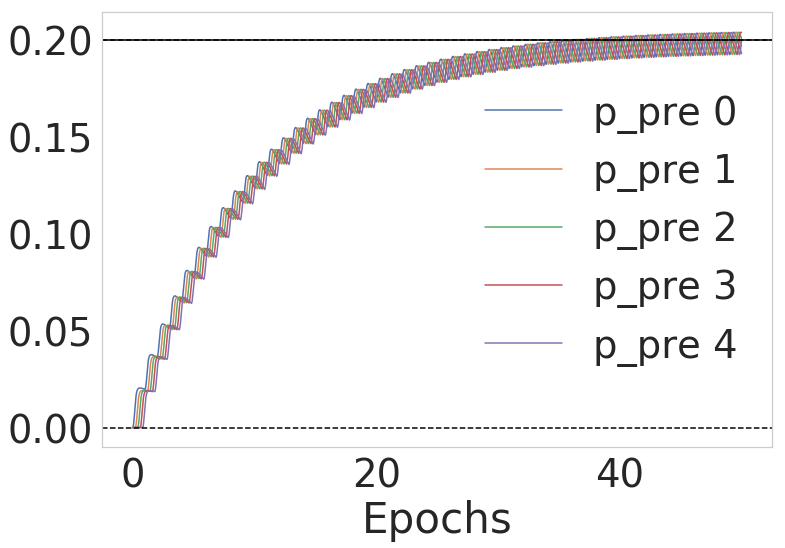

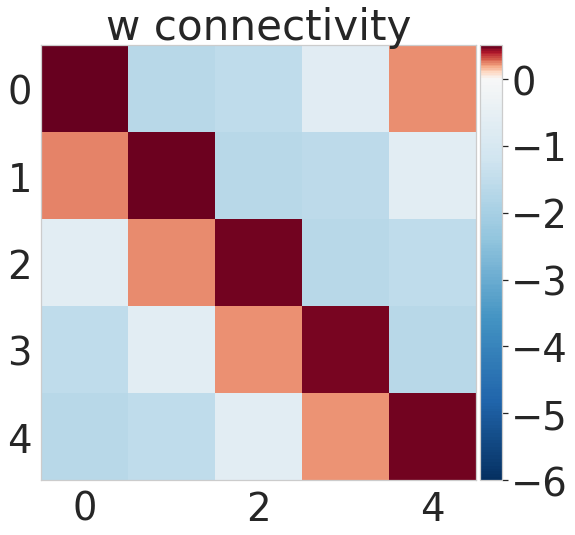

In [9]:
w = manager.history['w']
o = manager.history['o']
z_pre = manager.history['z_pre']
p_pre = manager.history['p_pre']
p_post = manager.history['p_post']
P = manager.history['P']
s = manager.history['s']
beta = manager.history['beta']

for index in range(minicolumns):
    plt.plot(manager.time / (training_times_base * n_patterns), p_pre[:, index], label='p_pre ' + str(index))
    
plt.axhline(1 / minicolumns , ls='--', color='black')
plt.axhline(training_times_base * epochs / (manager.T_training_total) , color='black', ls='-')
plt.axhline(0, ls='--', color='black')
# plt.axvline(10 * training_times_base * n_patterns, ls='--', color='red')

plt.legend(frameon=False)
#plt.xlim([150, 158])
plt.xlabel('Epochs')

plot_weight_matrix(manager, vmin=vmin)
w2 = np.copy(nn.w)

Text(0.5, 0, 'Epochs')

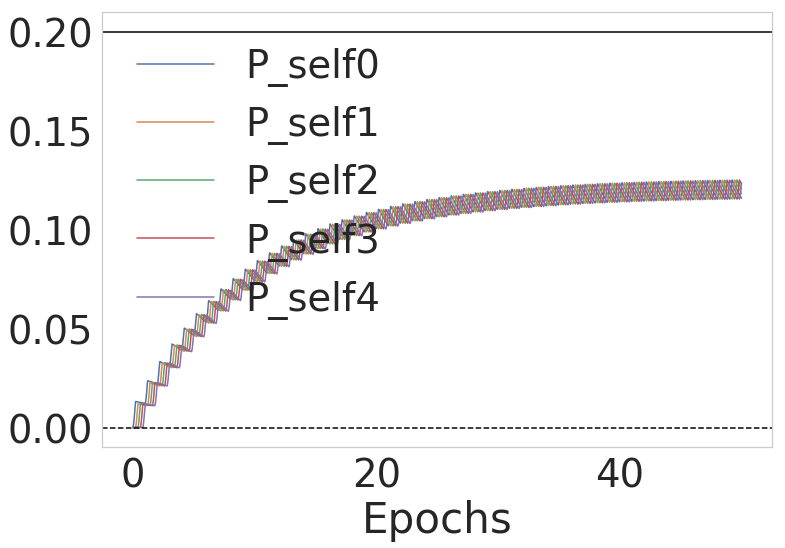

In [10]:
for index in range(minicolumns):
    plt.plot(manager.time / (training_times_base * n_patterns), P[:, index, index], label='P_self' + str(index))
    
# plt.axhline(1 / minicolumns , ls='--', color='black')
plt.axhline(training_times_base * epochs / (manager.T_training_total) , color='black', ls='-')
plt.axhline(0, ls='--', color='black')
# plt.axvline(10 * training_times_base * n_patterns, ls='--', color='red')

plt.legend(frameon=False)
#plt.xlim([150, 158])
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

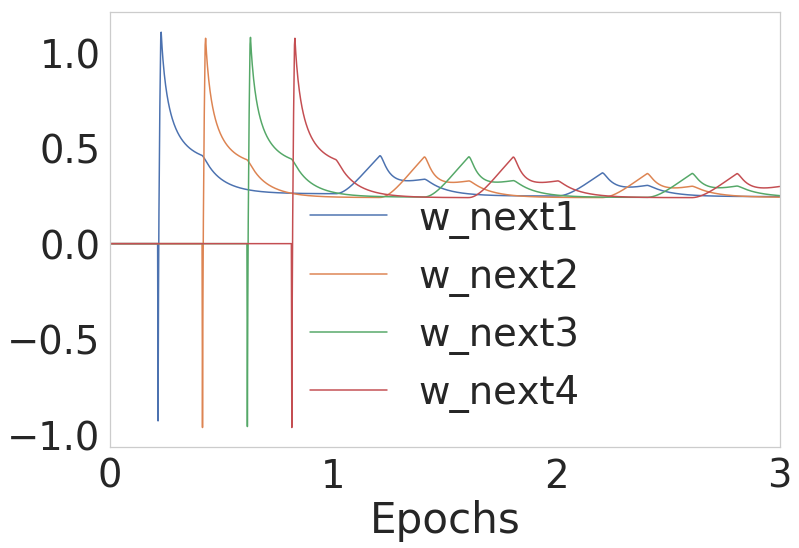

In [11]:
for index in range(1, minicolumns):
    plt.plot(manager.time / (training_times_base * n_patterns), w[:, index, index] - w[:, index, index - 1], label='w_next' + str(index))
    
# plt.axhline(1 / minicolumns , ls='--', color='black')
#plt.axhline(training_times_base * epochs / (manager.T_training_total) , color='black', ls='-')
#plt.axhline(0, ls='--', color='black')
# plt.axvline(10 * training_times_base * n_patterns, ls='--', color='red')

plt.legend(frameon=False)
plt.xlim([0, 3])
plt.xlabel('Epochs')

##### transition of w

Text(0.5, 0, 'Epochs')

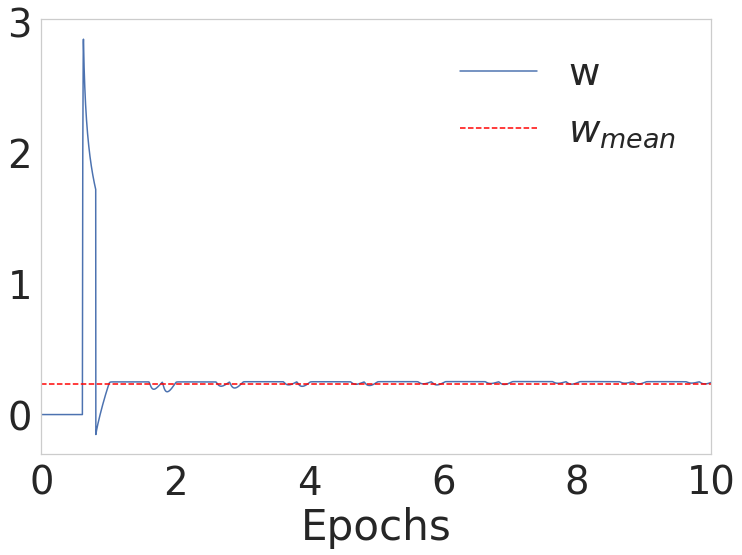

In [12]:
w = manager.history['w']
o = manager.history['o']
z_pre = manager.history['z_pre']
p_pre = manager.history['p_pre']
p_post = manager.history['p_post']
P = manager.history['P']
s = manager.history['s']
beta = manager.history['beta']

w_to_plot = w[:, 3, 3] - w[:, 4, 3]
plt.plot(manager.time / (training_times_base * n_patterns), w_to_plot, label='w')
    
#plt.axhline(training_times_base * epochs / (manager.T_training_total) , color='black', ls='-')
plt.axhline(w1[4, 3], ls='--', color='red', label=r'$w_{mean}$')
# plt.axvline(10 * training_times_base * n_patterns, ls='--', color='red')

plt.legend(frameon=False)
plt.xlim([0, 10])
plt.xlabel('Epochs')
# plt.ylim([0, 0.1])



Text(0.5, 0, 'Epochs')

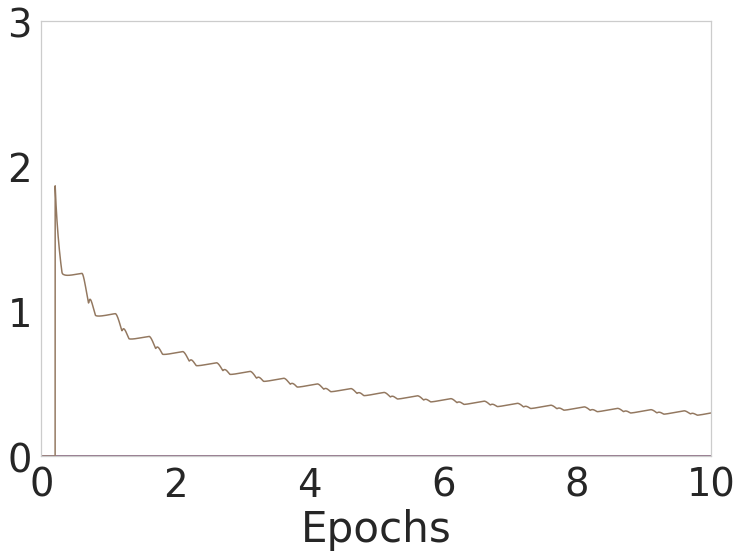

In [13]:
w_to_plot = w[:, 2, 1]

fig = plt.figure()
ax = fig.add_subplot(111)


for index in range(minicolumns):
    ax.plot(manager.time, 0. * o[:, index], label='o ' + str(index))

ax.plot(manager.time, w_to_plot, label='w')
    
plt.xlim([0, 10.0])
plt.ylim([0.0, 3.0])
# plt.axvline(10 * training_times_base * n_patterns, ls='--', color='red')

#plt.legend(frameon=False)
plt.xlabel('Epochs')

I need to superpose the effect of weight per-epochs to see when it increases

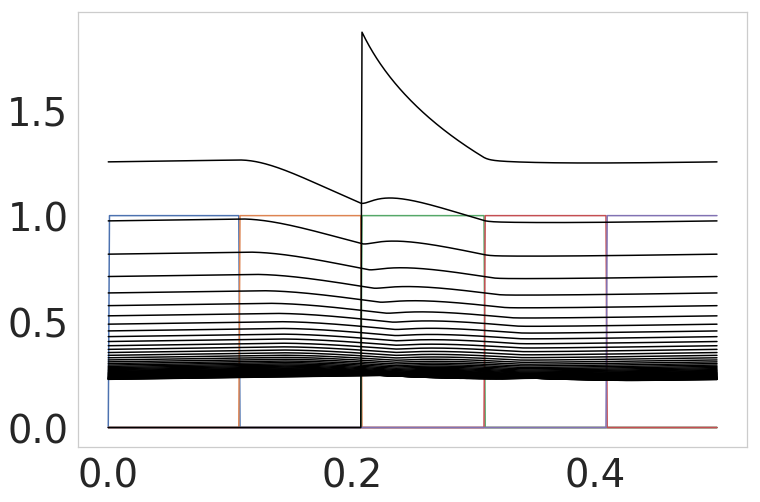

In [14]:
w = manager.history['w']
o = manager.history['o']
z_pre = manager.history['z_pre']
p_pre = manager.history['p_pre']
p_post = manager.history['p_post']
P = manager.history['P']
s = manager.history['s']
beta = manager.history['beta']


n_per_epoch = int(training_times_base * n_patterns / dt)
T_epoch = training_times_base * n_patterns 
time = np.linspace(0,T_epoch, n_per_epoch)


fig = plt.figure()
ax = fig.add_subplot(111)


if True:
    for index in range(minicolumns):
        ax.plot(time, o[:n_per_epoch, index], label='o ' + str(index))

for epoch in range(epochs):
    n_start = epoch * n_per_epoch
    n_end = (epoch + 1) * n_per_epoch
    ax.plot(time, w[n_start:n_end, 2, 1], color='black')

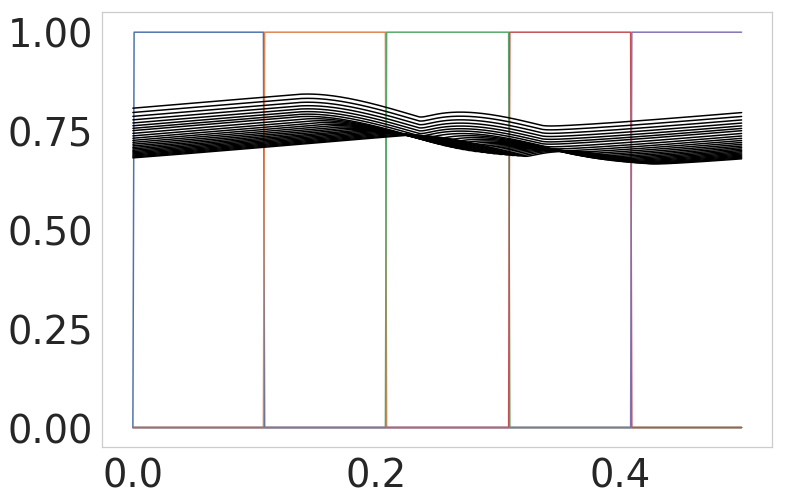

In [15]:
n_per_epoch = int(training_times_base * n_patterns / dt)
T_epoch = training_times_base * n_patterns 
time = np.linspace(0,T_epoch, n_per_epoch)

w = manager.history['w']
o = manager.history['o']
z_pre = manager.history['z_pre']
p_pre = manager.history['p_pre']
p_post = manager.history['p_post']
P = manager.history['P']
s = manager.history['s']
beta = manager.history['beta']

fig = plt.figure()
ax = fig.add_subplot(111)

if True:
    for index in range(minicolumns):
        ax.plot(time, o[:n_per_epoch, index], label='o ' + str(index))

for epoch in range(int(epochs/2), epochs):
    n_start = epoch * n_per_epoch
    n_end = (epoch + 1) * n_per_epoch
    ax.plot(time, 3 * w[n_start:n_end, 2, 1], color='black')

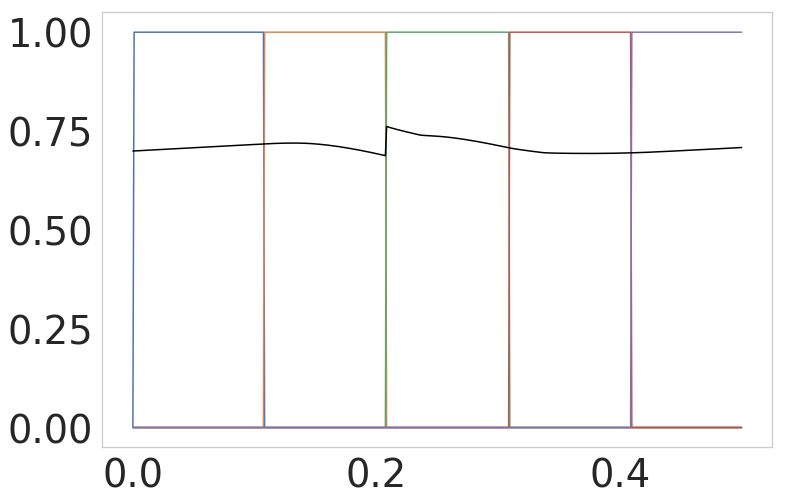

In [16]:
w_cuted = np.zeros((epochs, n_per_epoch))
for epoch in range(epochs):
    n_start = epoch * n_per_epoch
    n_end = (epoch + 1) * n_per_epoch
    w_cuted[epoch, :] = w[n_start:n_end, 2, 1]

w_mean = np.mean(w_cuted, axis=0)

fig = plt.figure()
ax = fig.add_subplot(111)

for index in range(minicolumns):
    ax.plot(time, o[:n_per_epoch, index], label='o ' + str(index))
ax.plot(time, 2* w_mean, color='black')
#ax.axhline(2 * w_added[0], color='black')


##### Look at the probabilities

Text(0.5, 0, 'Epochs')

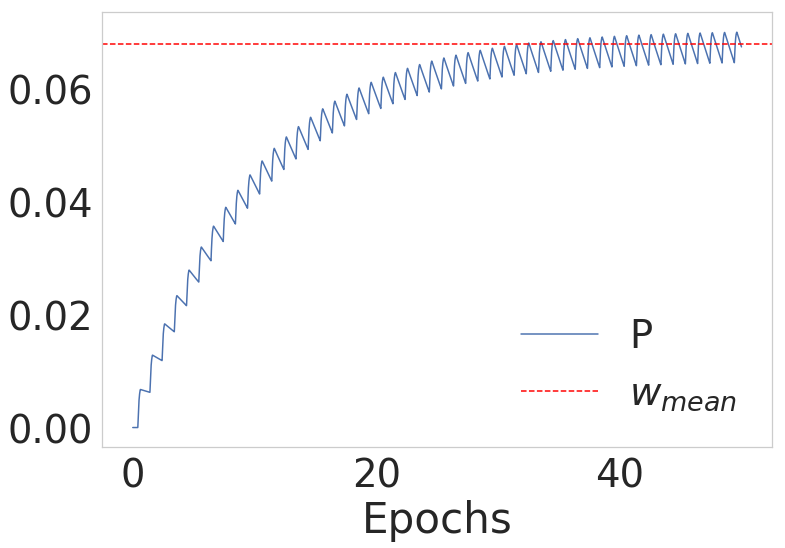

In [17]:
w = manager.history['w']
o = manager.history['o']
z_pre = manager.history['z_pre']
p_pre = manager.history['p_pre']
p_post = manager.history['p_post']
P = manager.history['P']
s = manager.history['s']
beta = manager.history['beta']

P_to_plot = P[:, 2, 1]
plt.plot(manager.time / (training_times_base * n_patterns), P_to_plot, label='P')
    
#plt.axhline(training_times_base * epochs / (manager.T_training_total) , color='black', ls='-')
plt.axhline(P1[4, 3], ls='--', color='red', label=r'$w_{mean}$')
# plt.axvline(10 * training_times_base * n_patterns, ls='--', color='red')

plt.legend(frameon=False)
#plt.xlim([150, 158])
plt.xlabel('Epochs')
# plt.ylim([0, 0.1])b

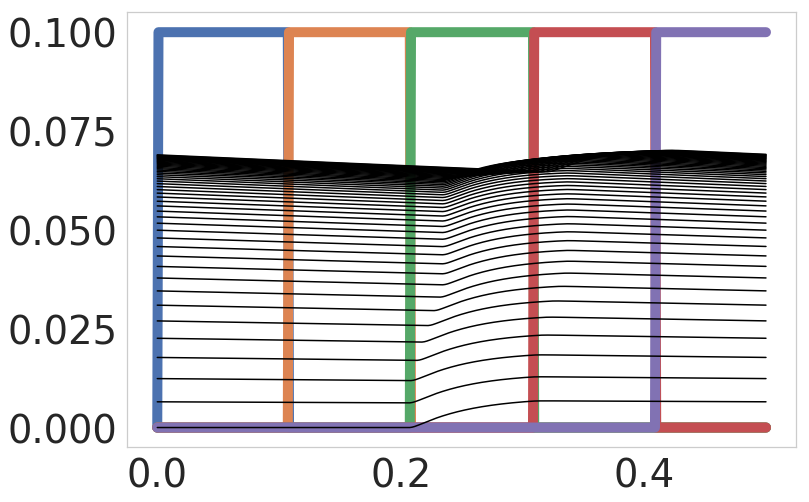

In [18]:
n_per_epoch = int(training_times_base * n_patterns / dt)
T_epoch = training_times_base * n_patterns 
time = np.linspace(0,T_epoch, n_per_epoch)


fig = plt.figure()
ax = fig.add_subplot(111)


if True:
    for index in range(minicolumns):
        ax.plot(time, o[:n_per_epoch, index]/ 10.0, lw=lw, label='o ' + str(index))

for epoch in range(epochs):
    n_start = epoch * n_per_epoch
    n_end = (epoch + 1) * n_per_epoch
    ax.plot(time, P[n_start:n_end, 2, 1], color='black')

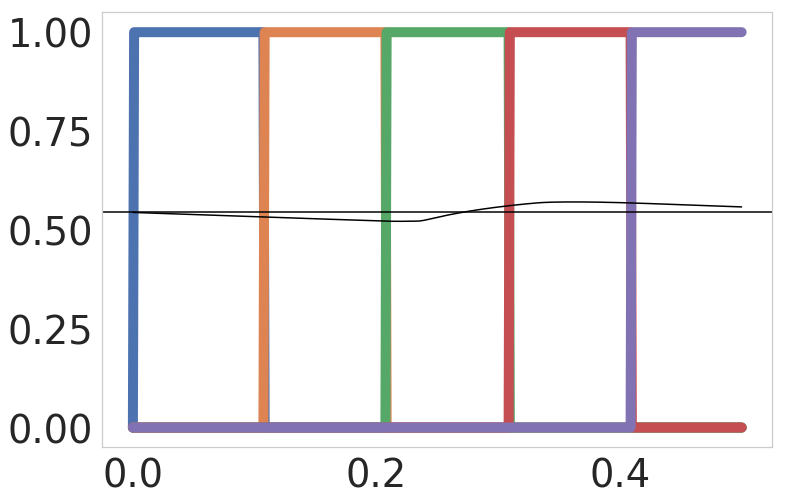

In [19]:
P_cuted = np.zeros((epochs, n_per_epoch))
for epoch in range(epochs):
    n_start = epoch * n_per_epoch
    n_end = (epoch + 1) * n_per_epoch
    P_cuted[epoch, :] = P[n_start:n_end, 2, 1]

P_mean = np.mean(P_cuted, axis=0)

fig = plt.figure()
ax = fig.add_subplot(111)

for index in range(minicolumns):
    ax.plot(time, o[:n_per_epoch, index] / 1.0, lw=lw, label='o ' + str(index))
ax.plot(time, 10 * P_mean, color='black')
ax.axhline(10 * P_mean[0], color='black')


Text(0.5, 0, 'Epochs')

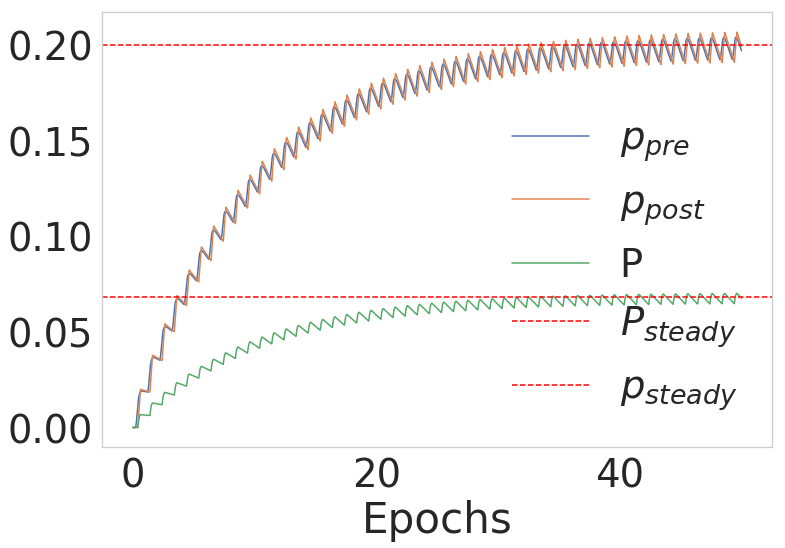

In [20]:
p_pre_to_plot = p_pre[:, 1]
p_post_to_plot = p_post[:,2]
P_to_plot = P[:, 2, 1]


plt.plot(manager.time / (training_times_base * n_patterns), p_pre_to_plot, label=r'$p_{pre}$')
plt.plot(manager.time / (training_times_base * n_patterns), p_post_to_plot, label=r'$p_{post}$')
plt.plot(manager.time / (training_times_base * n_patterns), P_to_plot, label='P')

plt.axhline(P1[4, 3], ls='--', color='red', label=r'$P_{steady}$')
plt.axhline(0.20, ls='--', color='red', label=r'$p_{steady}$')

plt.legend(frameon=False)
#plt.xlim([150, 158])
plt.xlabel('Epochs')
# plt.ylim([0, 0.1])b


Text(0.5, 0, 'Epochs')

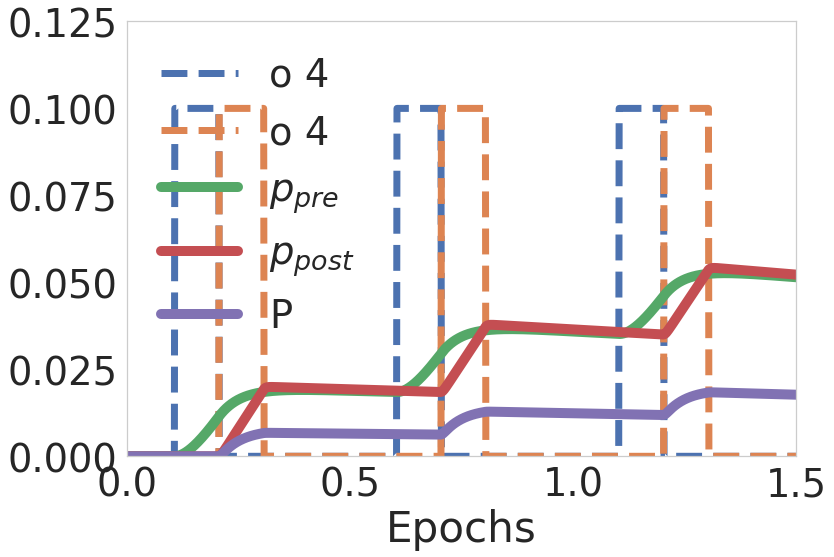

In [21]:
p_pre_to_plot = p_pre[:, 1]
p_post_to_plot = p_post[:,2]
P_to_plot = P[:, 2, 1]


plt.plot(manager.time, o[:, 1] / 10.0, lw=lw - 3, ls='--', label='o ' + str(index))
plt.plot(manager.time, o[:, 2] / 10.0, lw=lw - 3, ls='--', label='o ' + str(index))


plt.plot(manager.time, p_pre_to_plot, lw=lw, label=r'$p_{pre}$')
plt.plot(manager.time, p_post_to_plot, lw=lw, label=r'$p_{post}$')
plt.plot(manager.time, P_to_plot, lw=lw, label='P')

plt.legend(frameon=False)
plt.xlim([0, 1.5])
plt.ylim([0, 0.125])
plt.xlabel('Epochs')
# plt.ylim([0, 0.1])b

# Comparison to plot of training

In [22]:
num = 15

training_times = 0.100
inter_pulse_interval = 0.0
tau_z_pre = 0.025
tau_z_post = 0.020

index1 = 2
index2 = 3
index3 = 4

## Training time

In [23]:
%%time

training_times_vector = np.linspace(0.020, 1.0, num=num)
xlabel = r'$T_{p} $(s)'

values_dictionary = {name:np.zeros(num) for name in values_to_save_string}
values_dictionary['input'] = training_times_vector
values_dictionary['xlabel'] = xlabel


for index, tt in enumerate(training_times_vector):
    dic = calculate_connectivites(tt=tt, ipi=inter_pulse_interval, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post)
    for key in values_to_save_string:
        values_dictionary[key][index] = dic[key]

tt_dictionary = values_dictionary

../network.py:506: RuntimeWarning: invalid value encountered in log
  self.T = self.nn.tau_a * np.log(1 / (1 - self.B))
../network.py:510: RuntimeWarning: invalid value encountered in less
  self.T[self.T < 0] = 0.0


CPU times: user 2min 27s, sys: 16 s, total: 2min 43s
Wall time: 1min 36s


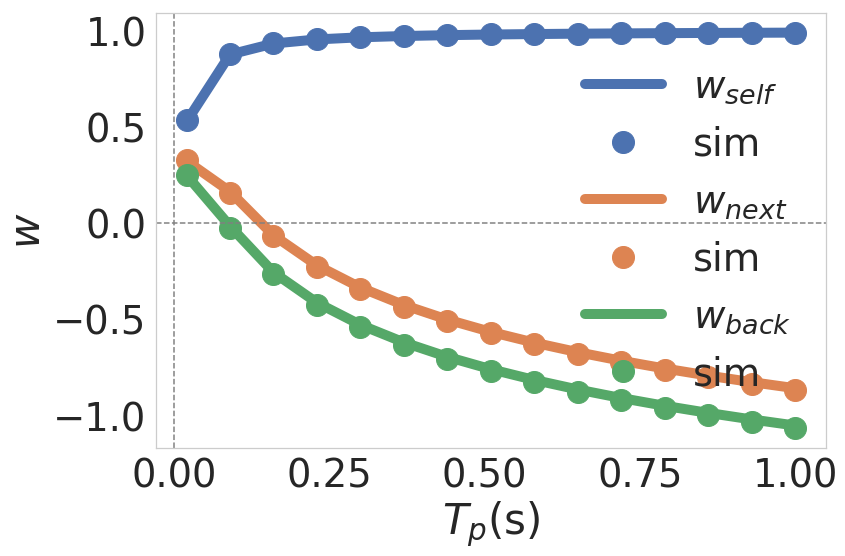

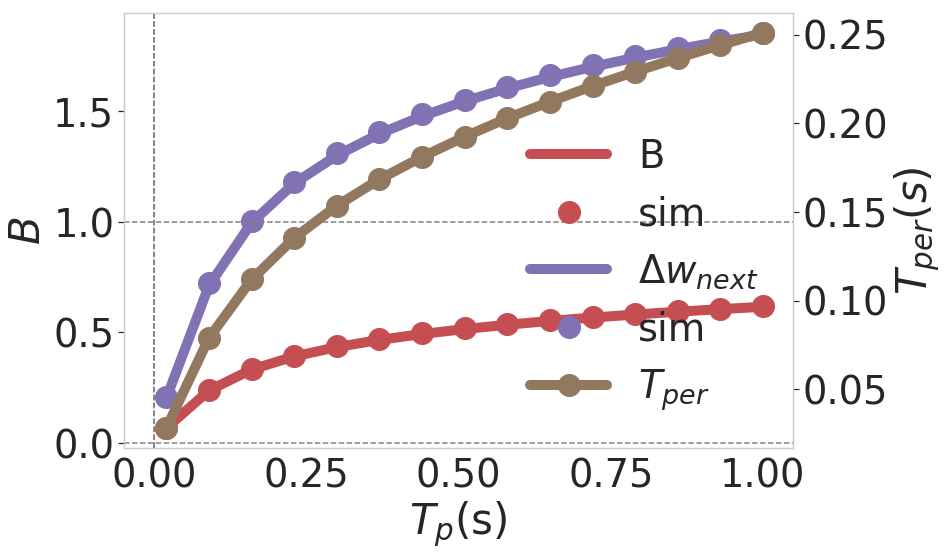

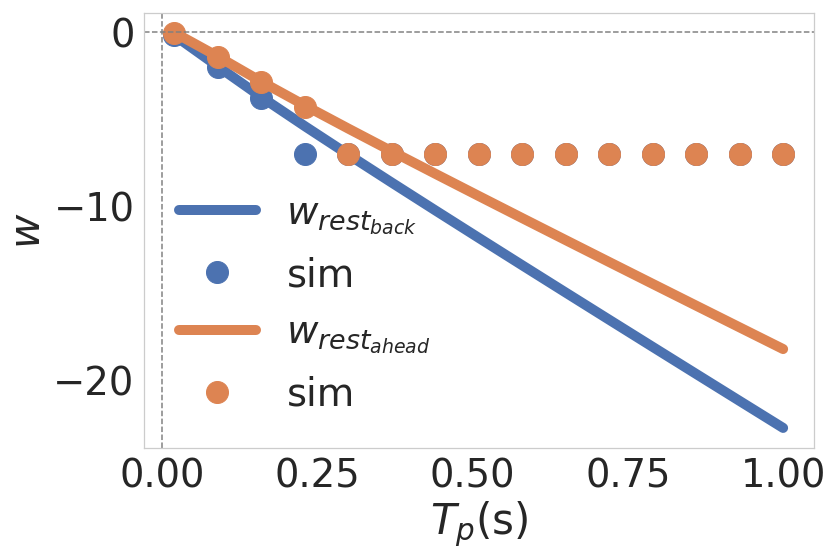

In [24]:
results_dictionary = tt_dictionary
plot_weights(results_dictionary)
ax = plot_B(results_dictionary, ax=None, legend=False)
axt = ax.twinx()
axt = plot_persistent_times(results_dictionary, ax=axt, legend=False);
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = axt.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, frameon=False)
plot_rest_weights(results_dictionary, ax=None, legend=True);

## Inter-pulse-interval

In [30]:
%%time

input_vector = np.linspace(0.0, 0.100, num=num)
xlabel = r'$IPI$ (s)'

values_dictionary = {name:np.zeros(num) for name in values_to_save_string}
values_dictionary['input'] = input_vector
values_dictionary['xlabel'] = xlabel


for index, ipi in enumerate(input_vector):
    dic = calculate_connectivites(tt=training_times, ipi=ipi, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post)
    for key in values_to_save_string:
        values_dictionary[key][index] = dic[key]

ipi_dictionary = values_dictionary

../network.py:506: RuntimeWarning: invalid value encountered in log
  self.T = self.nn.tau_a * np.log(1 / (1 - self.B))
../network.py:510: RuntimeWarning: invalid value encountered in less
  self.T[self.T < 0] = 0.0


CPU times: user 6min 8s, sys: 31.4 s, total: 6min 40s
Wall time: 3min 16s


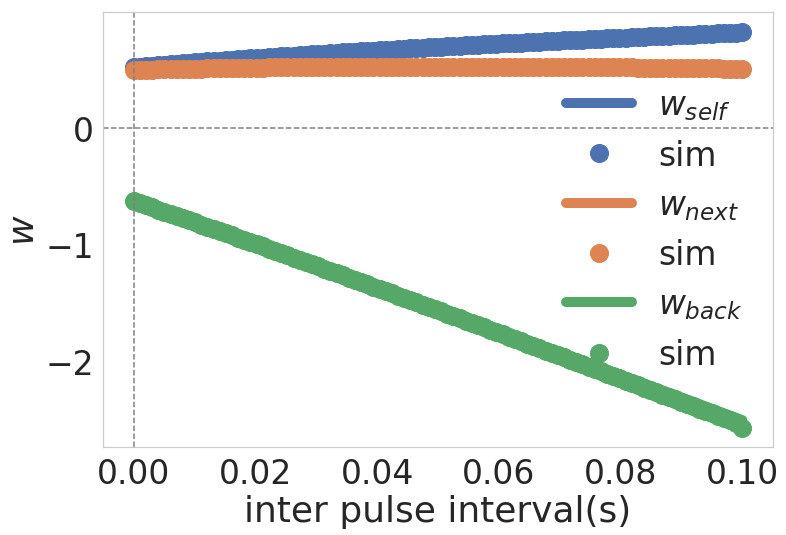

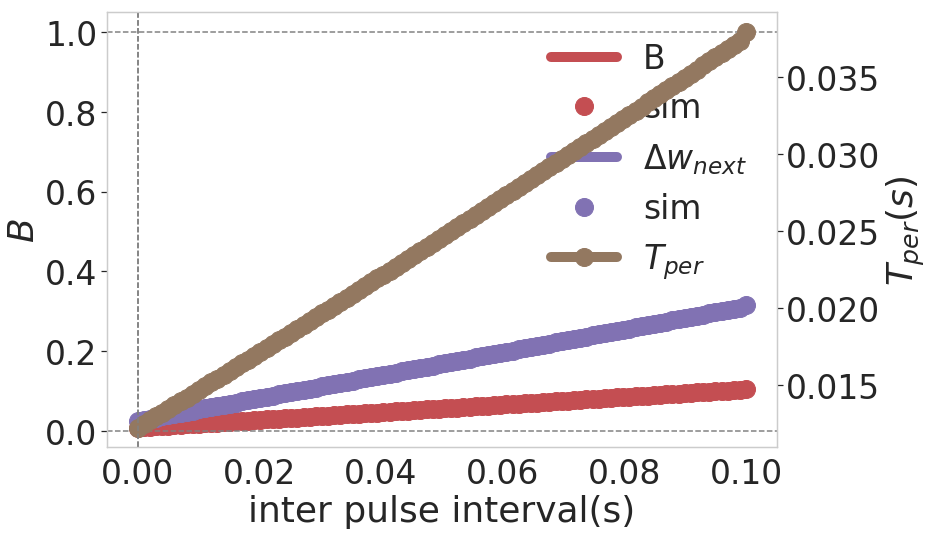

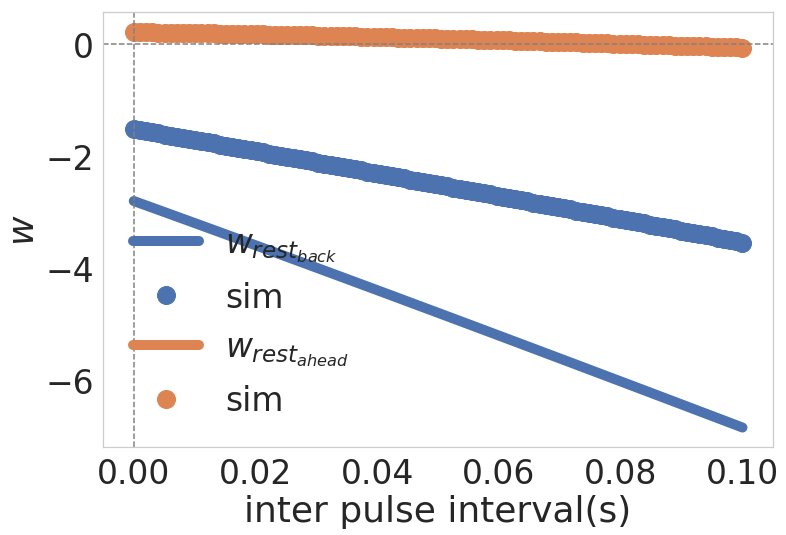

In [31]:
results_dictionary = ipi_dictionary
plot_weights(results_dictionary)
ax = plot_B(results_dictionary, ax=None, legend=False)
axt = ax.twinx()
axt = plot_persistent_times(results_dictionary, ax=axt, legend=False);
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = axt.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, frameon=False)
plot_rest_weights(results_dictionary, ax=None, legend=True);

## Tau_z

In [32]:
%%time

input_vector = np.linspace(0.005, 0.150, num=num)
xlabel = r'$\tau_{z_{pre}}$ (s)'

values_dictionary = {name:np.zeros(num) for name in values_to_save_string}
values_dictionary['input'] = input_vector
values_dictionary['xlabel'] = xlabel


for index, tau_z_pre in enumerate(input_vector):
    dic = calculate_connectivites(tt=training_times, ipi=inter_pulse_interval,
                                  tau_z_pre=tau_z_pre, tau_z_post=tau_z_post)
    for key in values_to_save_string:
        values_dictionary[key][index] = dic[key]

tau_z_dictionary = values_dictionary

../network.py:506: RuntimeWarning: invalid value encountered in log
  self.T = self.nn.tau_a * np.log(1 / (1 - self.B))
../network.py:510: RuntimeWarning: invalid value encountered in less
  self.T[self.T < 0] = 0.0


CPU times: user 4min 47s, sys: 24 s, total: 5min 11s
Wall time: 2min 22s


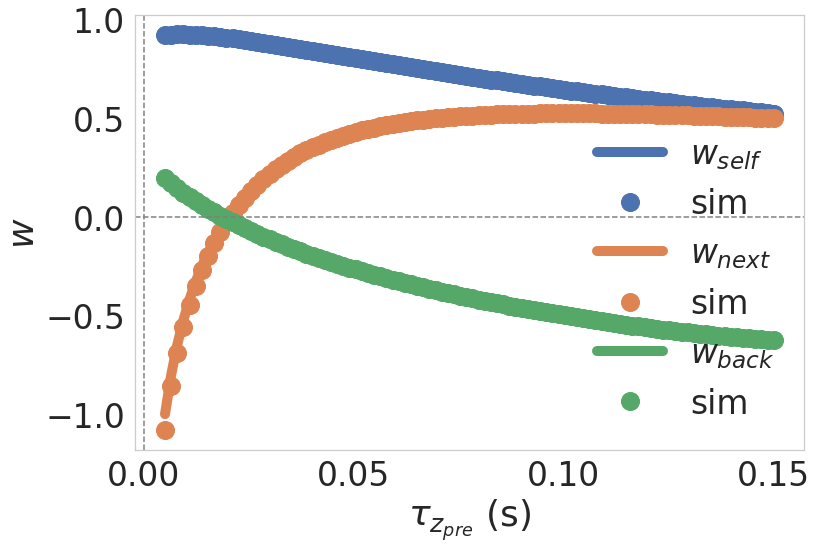

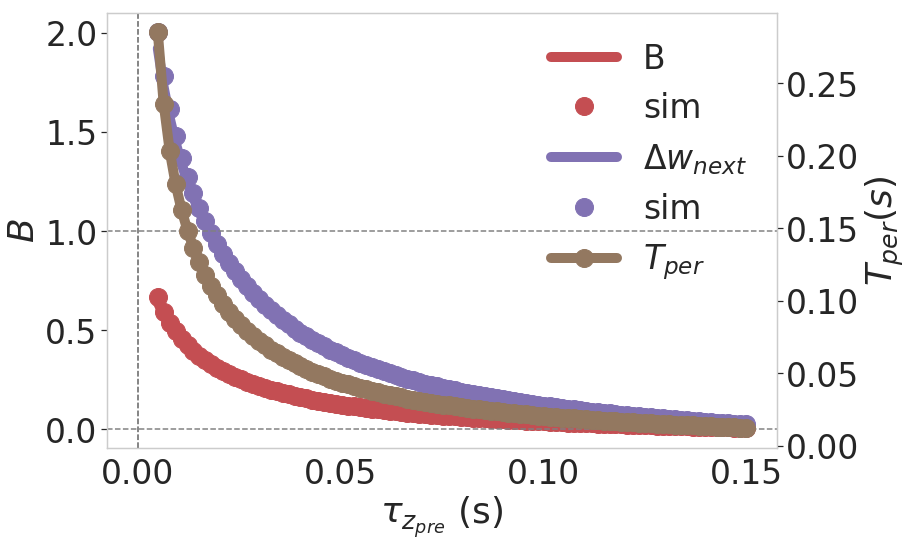

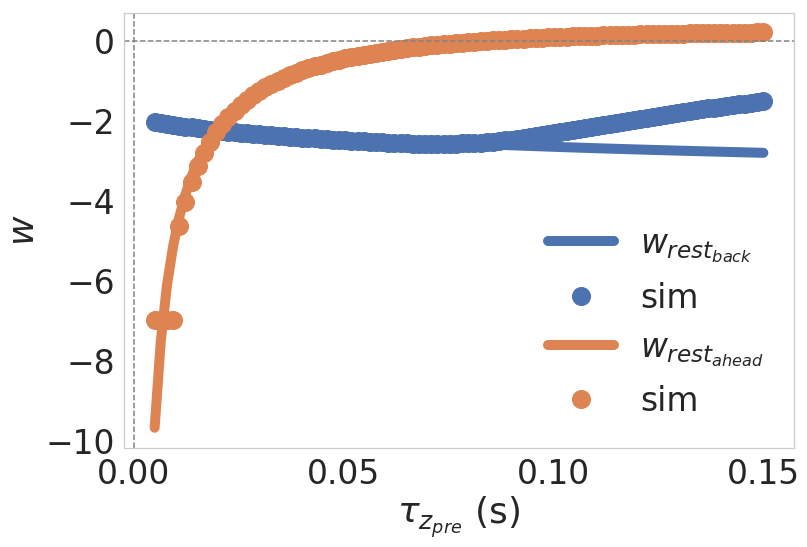

In [33]:
results_dictionary = tau_z_dictionary
plot_weights(results_dictionary)
ax = plot_B(results_dictionary, ax=None, legend=False)
axt = ax.twinx()
axt = plot_persistent_times(results_dictionary, ax=axt, legend=False);
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = axt.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, frameon=False)
plot_rest_weights(results_dictionary, ax=None, legend=True)


No handles with labels found to put in legend.


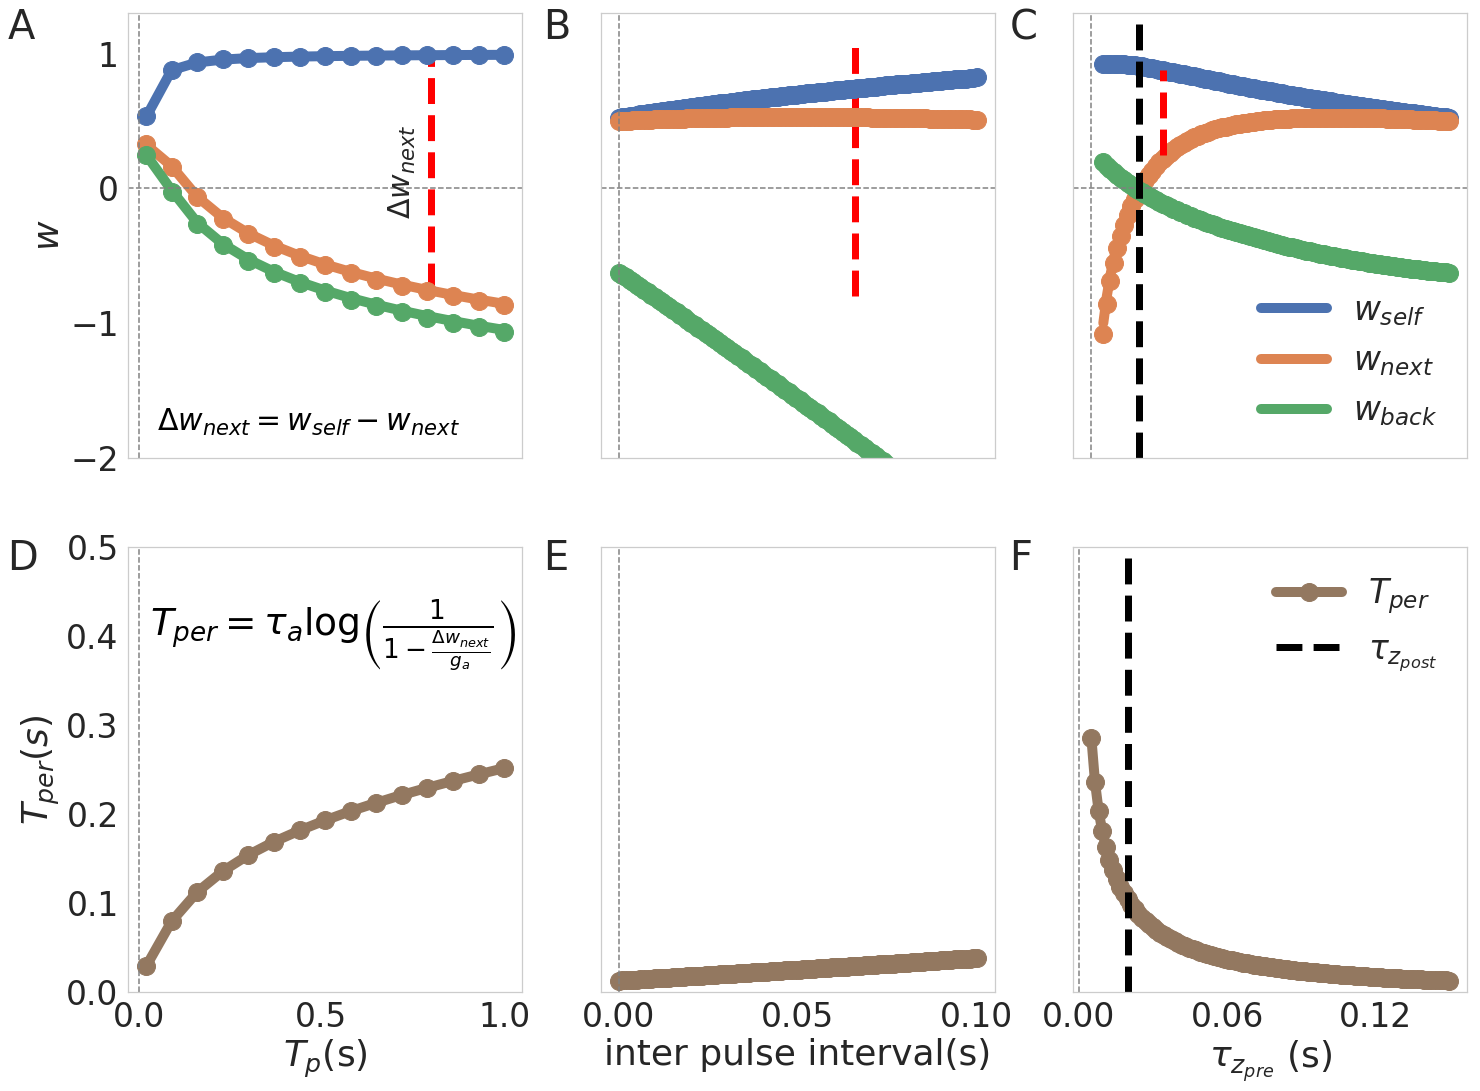

In [34]:
sns.set(font_scale=3.0)
sns.set_style("whitegrid", {'axes.grid': False})
size_factor = 1.5

lw = 10
ms = 18
save = True
captions = True
size = 10
legend = False
both_labels = False   # This controls that only the the labels for the theoretical points appear.
ylim = [-2.0, 1.3]
Tlim= [0, 0.500]
plot_persistences = True

fig = plt.figure(figsize=(int(size_factor * 16), int(size_factor * 12)))
gs = gridspec.GridSpec(2, 3)

#################
# Training time
################
results_dictionary = tt_dictionary

ax11 = fig.add_subplot(gs[0, 0])

# Add w_next line
num = 100
w_diff_x = np.ones(num) * 0.8
w_diff_y = np.linspace(-0.75, 1.0, num=100)
ax11.plot(w_diff_x, w_diff_y, ls='--', lw=lw - 3, color='red')
ax11.legend(frameon=False)

# Top
ax11 = plot_weights(results_dictionary, ax=ax11, legend=legend, x_label=False)
ax11.set_ylim(ylim)
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Bottom
ax21 = fig.add_subplot(gs[1, 0])
ax21 = plot_persistent_times(results_dictionary, ax=ax21, y_label=True, legend=False);
ax21.set_ylim(Tlim)

# Symbol for w_next
ax11.text(x=0.68, y=0.30, s=r'$\Delta w_{next}$', size=30.0, rotation=90)

# Equations
ax11_text = r'$\Delta w_{next} = w_{self} - w_{next}$'
ax11.text(x=0.050, y=-1.8, s=ax11_text, size=30.0, color='black')
math_text = r'$T_{per} = \tau_a \log \left( \frac{1}{1 - \frac{\Delta w_{next}}{g_a}} \right)$'
ax21.text(x=0.030, y= 0.4, s=math_text, size=37.5, color='black')

###############
# IPI
###############
results_dictionary = ipi_dictionary

ax12 = fig.add_subplot(gs[0, 1])

# Add w_next line
num = 100
w_diff_x = np.ones(num) * 0.066
w_diff_y = np.linspace(-0.80, 1.1, num=100)
ax12.plot(w_diff_x, w_diff_y, ls='--', lw=lw - 3, color='red', label=r'$\Delta w_{next}$')

# Top
ax12 = plot_weights(results_dictionary, ax=ax12, legend=legend, x_label=False, y_label=False)
ax12.set_ylim(ylim)
ax12.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, labelleft=False)

# Bottom
ax22 = fig.add_subplot(gs[1, 1])
ax22 = plot_persistent_times(results_dictionary, ax=ax22, y_label=False, legend=False);
ax22.set_ylim(Tlim)
ax22.tick_params(axis='y', which='both', labelleft=False)



#######################
# tau_z
######################3
results_dictionary = tau_z_dictionary

ax13 = fig.add_subplot(gs[0, 2])


# Top
ax13 = plot_weights(results_dictionary, ax=ax13, legend=True, x_label=False, y_label=False, both_labels=both_labels)
ax13.axvline(tau_z_post, ls='--',  lw=lw - 3, color='black', label=r'$\tau_{z_{post}}$')
ax13.set_ylim(ylim)
ax13.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, labelleft=False)

# Add w_next line
num = 100
w_diff_x = np.ones(num) * 0.030
w_diff_y = np.linspace(0.25, 0.88, num=100)
ax13.plot(w_diff_x, w_diff_y, ls='--', lw=lw - 3, color='red', label=r'$\Delta w_{next} = w_{self} - w_{next}$')

# Botoom
ax23 = fig.add_subplot(gs[1, 2])
ax23 = plot_persistent_times(results_dictionary, ax=ax23, y_label=False,  legend=False);
ax23.set_ylim(Tlim)
ax23.axvline(tau_z_post, ls='--', lw=lw - 3, color='black', label=r'$\tau_{z_{post}}$')
ax23.legend(frameon=False)
ax23.tick_params(axis='y', which='both', labelleft=False)
ax23.xaxis.set_major_locator(plt.MaxNLocator(3))



if captions:
    size = 40
    xpoint1 = 0.055
    xpoint2 = 0.365
    xpoint3 = 0.635
    
    ypoint1 = 0.86
    ypoint2 = 0.45
    
    fig.text(xpoint1, ypoint1, 'A', size=size)
    fig.text(xpoint2, ypoint1, 'B', size=size)
    fig.text(xpoint3, ypoint1, 'C', size=size)
    
    fig.text(xpoint1, ypoint2, 'D', size=size)
    fig.text(xpoint2, ypoint2, 'E', size=size)
    fig.text(xpoint3, ypoint2, 'F', size=size)

if save:
    directory = '../plot_producers/'
    file_name = 'training' 
    format_string = '.pdf'
    string_to_save = directory + file_name + format_string
    fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight')

# See the evolution of weights